In [4]:
# 
import pandas as pd
import numpy as np
import re
import time
import pickle

# 
import requests 

#
from sklearn.model_selection import train_test_split

# 
from sklearn.preprocessing import MinMaxScaler

from sklearn.linear_model import Lasso


from sklearn.feature_selection import SelectFromModel


# for Q-Q plots
import pylab
import scipy.stats as stats

# for plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# to display all the columns of a dataframe
pd.pandas.set_option('display.max_columns', None)

In [5]:
# loading the dataset
df = pd.read_csv ('treb_history.txt', delimiter = '\t') # House price Dataset

print(df.shape)

# visualising the dataset
df.head(2)

(653171, 36)


,Unnamed: 0,id,type,province,community,postcode,bedrooms,bedroomplus,washrooms,kitchens,bedroomstotal,propertytype,approxage,approxsqft,price,soldprice,laststatus,mlsnumber,brokeragename,contractdate,solddate,closeddate,terminateddate,entrydate,updatedtimestamp,propertynew,city,crossstreets,maintenancefee,area,fronton,longitude,latitude,coop,sprice,lprice
0,0,"{""$oid"":""59dd1c1519bd90351291bbd8""}",Sale,Ontario,Willowdale East,M2N6X5,1.0,NaN,1.0,1.0,1,Condo Apt,NaN,600-699,300000.0,NaN,Sus,C3160165,"CENTURY 21 PERCY FULTON LTD., BROKERAGE",2015-04-07,NaN,NaN,NaN,2015-04-07,2018-03-13 05:56:39,Condo,Toronto,Yonge/Finch,341.81,Toronto,NaN,NaN,NaN,NaN,NaN,NaN
1,1,"{""$oid"":""59d526eba219a85352c2fd10""}",Sale,Ontario,Niagara,M5V1B2,2.0,NaN,2.0,1.0,2,Condo Apt,6-10,800-899,436800.0,NaN,Ter,C3240681,"CENTURY 21 LEADING EDGE REALTY INC., BROKERAGE",2015-06-22,NaN,NaN,2015-09-19,2015-06-22,2018-03-13 05:56:39,Condo,Toronto,Bathurst / Lakeshore,511.00,Toronto,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
df.dtypes # variable types

Unnamed: 0            int64
id                   object
type                 object
province             object
community            object
postcode             object
bedrooms            float64
bedroomplus         float64
washrooms           float64
kitchens            float64
bedroomstotal         int64
propertytype         object
approxage            object
approxsqft           object
price               float64
soldprice           float64
laststatus           object
mlsnumber            object
brokeragename        object
contractdate         object
solddate             object
closeddate           object
terminateddate       object
entrydate            object
updatedtimestamp     object
propertynew          object
city                 object
crossstreets         object
maintenancefee      float64
area                 object
fronton              object
longitude           float64
latitude            float64
coop                 object
sprice              float64
lprice              

# 1. Data Analysis and Basic Cleaning

In [7]:
# list of the variables that contain missing values
vars_with_na = [var for var in df.columns if df[var].isnull().sum()>1]

d={}

# rounding missing values to three decimal places
for var in vars_with_na:
    d[var]= np.round(df[var].isnull().mean(), 3)

#Sorting missing values in Variables in DESC manner

sd= (sorted(d.items(), key =lambda kv:(kv[1], kv[0]), reverse= True))

sd
 

[('longitude', 0.895),
 ('latitude', 0.895),
 ('lprice', 0.785),
 ('maintenancefee', 0.772),
 ('terminateddate', 0.734),
 ('bedroomplus', 0.597),
 ('sprice', 0.589),
 ('approxage', 0.558),
 ('fronton', 0.398),
 ('closeddate', 0.379),
 ('soldprice', 0.373),
 ('solddate', 0.373),
 ('coop', 0.371),
 ('approxsqft', 0.318),
 ('kitchens', 0.006),
 ('bedrooms', 0.006),
 ('postcode', 0.001),
 ('washrooms', 0.0),
 ('province', 0.0),
 ('propertytype', 0.0),
 ('crossstreets', 0.0),
 ('community', 0.0)]

In [8]:
df.columns

Index(['Unnamed: 0', 'id', 'type', 'province', 'community', 'postcode',
       'bedrooms', 'bedroomplus', 'washrooms', 'kitchens', 'bedroomstotal',
       'propertytype', 'approxage', 'approxsqft', 'price', 'soldprice',
       'laststatus', 'mlsnumber', 'brokeragename', 'contractdate', 'solddate',
       'closeddate', 'terminateddate', 'entrydate', 'updatedtimestamp',
       'propertynew', 'city', 'crossstreets', 'maintenancefee', 'area',
       'fronton', 'longitude', 'latitude', 'coop', 'sprice', 'lprice'],
      dtype='object')

In [9]:
# Taking relevant cols(e.g. dropping id) only and choosing among similar cols based on lesser missing values
#(e.g. bedroomstotal instead of bedrooms )

In [10]:
cols=['postcode','province','city','area','community','type','approxage','approxsqft','propertynew','bedroomstotal','kitchens','washrooms','maintenancefee','entrydate','solddate','soldprice','latitude','longitude']

In [11]:
df=df[cols]

In [12]:
df.head(1)

,postcode,province,city,area,community,type,approxage,approxsqft,propertynew,bedroomstotal,kitchens,washrooms,maintenancefee,entrydate,solddate,soldprice,latitude,longitude
0,M2N6X5,Ontario,Toronto,Toronto,Willowdale East,Sale,NaN,600-699,Condo,1,1.0,1.0,341.81,2015-04-07,NaN,NaN,NaN,NaN


In [13]:
df.shape

(653171, 18)

## Filtering 'type' to only 'Sale'

In [14]:
df['type'].unique()

array(['Sale', 'Lease'], dtype=object)

In [15]:
df=df[df['type']=='Sale']

In [16]:
df['type'].unique() # checking that Sale only exists

array(['Sale'], dtype=object)

In [17]:
df.shape

(452566, 18)

In [18]:
df['postcode'].nunique()

91096

## PostCode Cleaning

In [19]:
    df['postcode'] = df['postcode'].str.upper()
    df['postcode'] = df['postcode'].str.replace(' ', '')
    df['postcode'] = df['postcode'].str.replace('-', '')
    df=df[df['postcode'].str.len()==6] 
    # POSTCODE in CANADA consists of 6 digits[alternate Letters and Numbers]

In [20]:
df['postcode'].nunique()

73215

In [21]:
# POSTCODE of ONTARIO starts with any of  K,L,M,N,P[ 6 digits and alternate Letters and Numbers]

In [22]:
df=df[df['postcode'].str.contains('^[KLMNP]{1}[0-9]{1}[a-zA-Z]{1}[- ]{0,1}[0-9]{1}[a-zA-Z]{1}[0-9]{1}',regex=True)]

In [23]:
df['postcode'].nunique()

72216

In [24]:
df['city'].nunique() # Has records for all 50 cities

50

In [25]:
df.shape

(448730, 18)

In [26]:
# Imputing missing values for 'province' to 'Ontario' flatly

In [27]:
df['province']='Ontario' # 

## Exploring Numerical Variables

In [28]:
# list of numerical variables
num_vars = [var for var in df.columns if df[var].dtypes != 'O']

print('Number of numerical variables: ', len(num_vars))

# visualising the numerical variables
df[num_vars].head()

Number of numerical variables:  7


,bedroomstotal,kitchens,washrooms,maintenancefee,soldprice,latitude,longitude
0,1,1.0,1.0,341.81,NaN,NaN,NaN
1,2,1.0,2.0,511.00,NaN,NaN,NaN
2,5,1.0,3.0,NaN,NaN,NaN,NaN
3,2,1.0,2.0,935.00,NaN,NaN,NaN
4,2,1.0,2.0,516.00,NaN,NaN,NaN


### Discrete Numerical Variables

In [29]:
#  list of discrete variables 
## Setting the cutoff to 36 based on the max no. of washrooms
discrete_vars = [var for var in num_vars if len(df[var].unique())<36]

print('Number of discrete variables: ', len(discrete_vars))

Number of discrete variables:  3


In [30]:
#visualising the discrete variables
df[discrete_vars].sort_values(by='washrooms',ascending=False).head()

,bedroomstotal,kitchens,washrooms
513552,18,9.0,35.0
232359,18,9.0,27.0
112864,0,0.0,27.0
110960,18,9.0,24.0
578358,0,0.0,24.0


In [31]:
df['washrooms'].unique() # 35 washrooms looks too much

array([ 1.,  2.,  3.,  5., 12.,  4.,  6.,  7.,  9.,  8.,  0., 10., 14.,
       11., 16., 13., 18., 15., 24., 27., nan, 17., 35.])

In [32]:
df[df['washrooms']>4][['postcode','city','washrooms','approxsqft']].sort_values(by='washrooms',ascending=False).head(7)

# Areas also look bigger where no of washrooms are higher( makes sense)

,postcode,city,washrooms,approxsqft
513552,M6K2J6,Toronto,35.0,5000+
112864,M5R1W8,Toronto,27.0,NaN
232359,M4J2L1,Toronto,27.0,NaN
110960,M4Y2G6,Toronto,24.0,NaN
578358,M6K2H9,Toronto,24.0,5000+
35032,M5A2A5,Toronto,18.0,5000+
59740,M5A2A5,Toronto,18.0,5000+


In [33]:
# How Discrete variables affect Sale Price

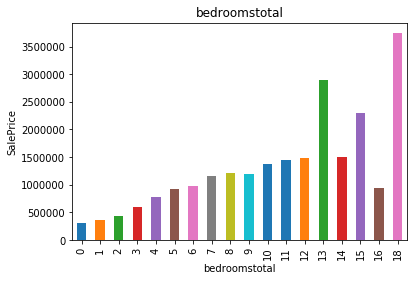

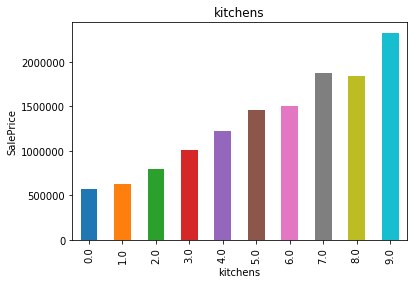

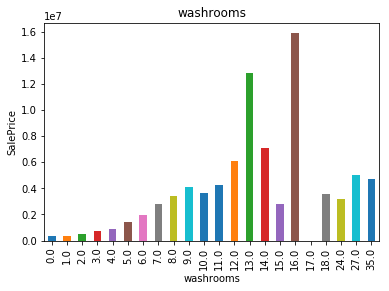

In [34]:
def analyse_discrete(df, var):
    df = df.copy()
    df.groupby(var)['soldprice'].median().plot.bar()
    plt.title(var)
    plt.ylabel('SalePrice')
    plt.show()
    
for var in discrete_vars:
    analyse_discrete(df, var)

In [35]:
#### No monotonic relation found

### Continuous Numerical Variables

In [36]:
# list of continuous variables
cont_vars = [var for var in num_vars if var not in discrete_vars]

print('Number of continuous variables: ', len(cont_vars))

Number of continuous variables:  4


In [37]:
df[cont_vars].head()

,maintenancefee,soldprice,latitude,longitude
0,341.81,NaN,NaN,NaN
1,511.00,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN
3,935.00,NaN,NaN,NaN
4,516.00,NaN,NaN,NaN


In [38]:
l2=['latitude','longitude']

In [39]:
cont_vars= [x for x in cont_vars if x not in l2] # dropping lats and longs

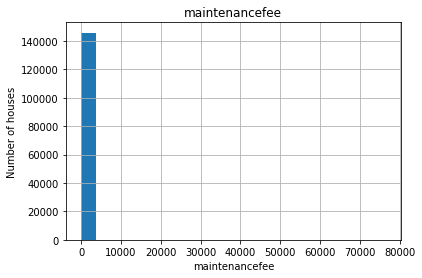

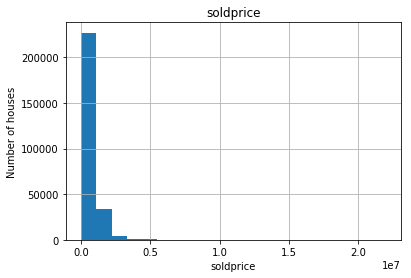

In [40]:
# analysing the distributions of the continious numerical variables
def analyse_continous(df, var):
    df = df.copy()
    df[var].hist(bins=20)
    plt.ylabel('Number of houses')
    plt.xlabel(var)
    plt.title(var)
    plt.show()
    
for var in cont_vars:
    analyse_continous(df, var)

In [41]:
# All distributions look skewed

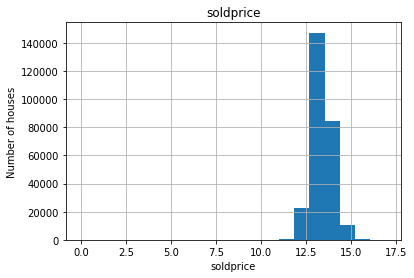

In [42]:
# checking log-distributions of these variables
def analyse_transformed_continous(df, var):
    df = df.copy()
    
    # log does not take negative values or zero, so skipping those variables(e.g.maintenancefee)
    if 0 in df[var].unique():
        pass
    else:
        # log transform the variable
        df[var] = np.log(df[var])
        df[var].hist(bins=20)
        plt.ylabel('Number of houses')
        plt.xlabel(var)
        plt.title(var)
        plt.show()
    
for var in cont_vars:
    analyse_transformed_continous(df, var)

In [43]:
# sold price becomes a Gaussian Distribution

In [44]:
df.head(1)

,postcode,province,city,area,community,type,approxage,approxsqft,propertynew,bedroomstotal,kitchens,washrooms,maintenancefee,entrydate,solddate,soldprice,latitude,longitude
0,M2N6X5,Ontario,Toronto,Toronto,Willowdale East,Sale,NaN,600-699,Condo,1,1.0,1.0,341.81,2015-04-07,NaN,NaN,NaN,NaN


## Outlier detection for Continious Numerical Variable

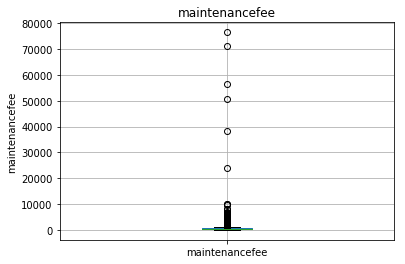

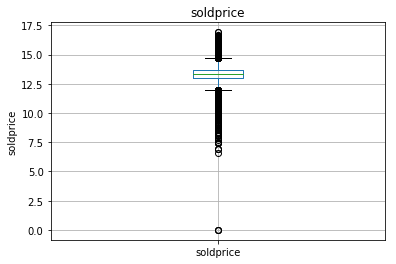

In [45]:
# making boxplots to visualise outliers in the continuous variables 

def find_outliers(df, var):
    df = df.copy()
    
    # log does not take negative values or zero,so taking normal 
    #value for those vars(e.g.maintenancefee)
    if 0 in df[var].unique():
        df[var] = df[var]
        df.boxplot(column=var)
        plt.title(var)
        plt.ylabel(var)
        plt.show()
    else:
        df[var] = np.log(df[var])
        df.boxplot(column=var)
        plt.title(var)
        plt.ylabel(var)
        plt.show()
    
for var in cont_vars:
    find_outliers(df, var)

In [46]:
# good numbers of outliers can be seen for each variable 

In [47]:
#  sns does not take var with NaN so creating another df i.e. df1 just for the sake of plotting 
#and wiping out NaNs

In [48]:
df1=df[(df['soldprice'].isnull()==False) & (df['maintenancefee'].isnull()==False)]

In [49]:
def diagnostic_plots_outliers(df, variable):

    df = df.copy()
    
    # log does not take negative values and zero
    if 0 in df[variable].unique():
        #df[variable]=df[variable]
        pass
    else:
        # log transform the variable
        df[variable] = np.log(df[variable])

    # defining figure size
    plt.figure(figsize=(16, 4))

    # histogram
    plt.subplot(1, 3, 1)
    sns.distplot(df[variable], bins=30)
    plt.title('Histogram')
    
    
    # Q-Q plot
    plt.subplot(1, 3, 2)
    stats.probplot(df[variable], dist="norm", plot=pylab)
    plt.ylabel('RM quantiles')   
    

    # boxplot
    plt.subplot(1, 3, 3)
    sns.boxplot(y=df[variable])
    plt.title('Boxplot')

    plt.show()

/Users/parijatbandyopadhyay/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


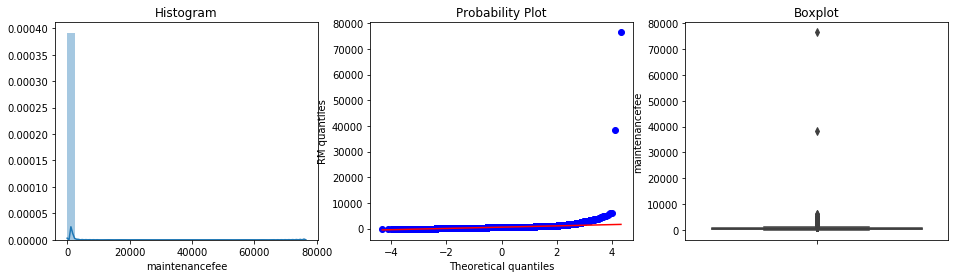

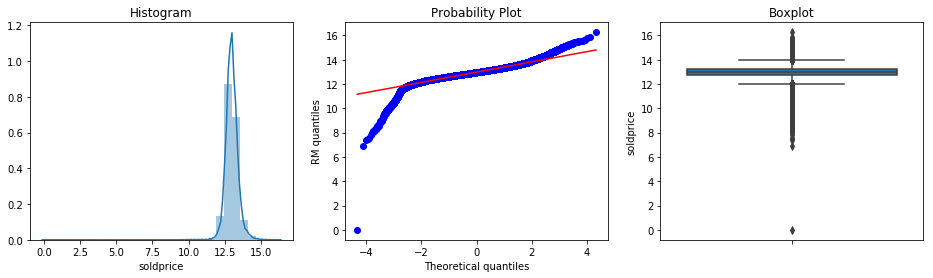

In [50]:
for var in cont_vars:
    diagnostic_plots_outliers(df1, var)

# Exploring Categorical Variables

In [51]:
### Categorical variables

cat_vars = [var for var in df.columns if df[var].dtypes=='O']

print('Number of categorical variables: ', len(cat_vars))

Number of categorical variables:  11


In [52]:
df[cat_vars].head(1)

,postcode,province,city,area,community,type,approxage,approxsqft,propertynew,entrydate,solddate
0,M2N6X5,Ontario,Toronto,Toronto,Willowdale East,Sale,NaN,600-699,Condo,2015-04-07,NaN


# Time Variables 

In [53]:
time_vars = [var for var in cat_vars if 'date' in var]

time_vars

['entrydate', 'solddate']

In [54]:
df.shape

(448730, 18)

## Cleaning for time variables

In [55]:
df= df[df['solddate'].isnull()==False] 
# Imputation is not possible for time variables so eliminating all NaNs in solddate

In [56]:
df['YM']=pd.to_datetime(df['solddate'], format='%Y-%m-%d').dt.to_period('M').astype(str) 

# Feature creation: YM , for sorting purpose later

In [57]:
df[df.solddate.isnull()==True].head(3)

,postcode,province,city,area,community,type,approxage,approxsqft,propertynew,bedroomstotal,kitchens,washrooms,maintenancefee,entrydate,solddate,soldprice,latitude,longitude,YM


In [58]:
 listYearMonth = df.sort_values(['YM'])['YM'].unique() # sorting based on YM

In [59]:
listYearMonth

array(['2003-10', '2015-09', '2015-10', '2015-11', '2015-12', '2016-01',
       '2016-02', '2016-03', '2016-04', '2016-05', '2016-06', '2016-07',
       '2016-08', '2016-09', '2016-10', '2016-11', '2016-12', '2017-01',
       '2017-02', '2017-03', '2017-04', '2017-05', '2017-06', '2017-07',
       '2017-08', '2017-09', '2017-10', '2017-11', '2017-12', '2018-01',
       '2018-02', '2018-03', '2018-04', '2018-05', '2018-06'],
      dtype=object)

In [60]:
TrainMonth= listYearMonth[-6:] # taking only last 6 months data based on 'solddate'

In [61]:
TrainMonth

array(['2018-01', '2018-02', '2018-03', '2018-04', '2018-05', '2018-06'],
      dtype=object)

In [62]:
df = df.loc[df['YM'].isin(TrainMonth)] # filtering df based on last 6 months and based on solddate

In [63]:
df.head(1)

,postcode,province,city,area,community,type,approxage,approxsqft,propertynew,bedroomstotal,kitchens,washrooms,maintenancefee,entrydate,solddate,soldprice,latitude,longitude,YM
116274,M5V0C4,Ontario,Toronto,Toronto,Waterfront Communities C1,Sale,0-5,900-999,Condo,3,1.0,2.0,536.53,2017-07-27,2018-03-09,880000.0,43.646,-79.3899,2018-03


In [64]:
df.shape

(39611, 19)

In [65]:
    df['lifeofad'] = (pd.to_datetime(df['solddate'],format='%Y-%m-%d') - pd.to_datetime(df['entrydate'],format='%Y-%m-%d')).dt.days
    
    # Feature Creation: df['lifeofad'] = df['solddate'] - df['entrydate'] 
    # to take the effect of time
    
    df=df[df['lifeofad']<=180] 
    
    # Further taking only ADs that lasted for less than or equal to 180 days
    #i.e propery got sold within 6 months of entry


In [66]:
df.head(1)

,postcode,province,city,area,community,type,approxage,approxsqft,propertynew,bedroomstotal,kitchens,washrooms,maintenancefee,entrydate,solddate,soldprice,latitude,longitude,YM,lifeofad
122817,M2P1S4,Ontario,Toronto,Toronto,St. Andrew-Windfields,Sale,NaN,3500-5000,Detached,5,1.0,6.0,NaN,2017-09-07,2018-01-29,3250000.0,43.7568,-79.4012,2018-01,144


In [67]:
df.shape # not much loss of records

(39551, 20)

In [68]:
### Plotting time vs sale price

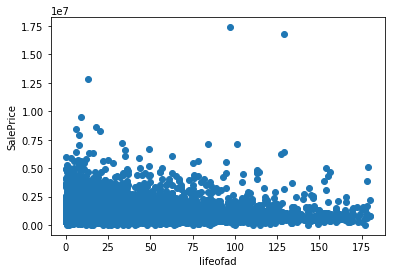

In [69]:
plt.scatter(df['lifeofad'], df['soldprice'])
plt.ylabel('SalePrice')
plt.xlabel('lifeofad')
plt.show()



Text(0.5, 1.0, 'Change in House price with ADLife')

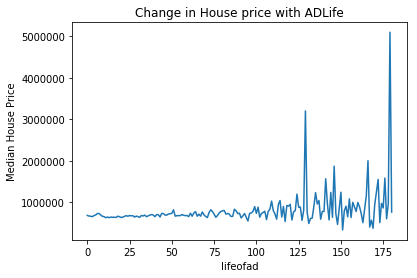

In [70]:
df.groupby('lifeofad')['soldprice'].median().plot()
plt.ylabel('Median House Price')
plt.title('Change in House price with ADLife')

# Exploring Categorical Variables (Continued)

In [71]:
cat_vars=[x for x in cat_vars if x not in time_vars]

In [72]:
df[cat_vars].head(1)

,postcode,province,city,area,community,type,approxage,approxsqft,propertynew
122817,M2P1S4,Ontario,Toronto,Toronto,St. Andrew-Windfields,Sale,NaN,3500-5000,Detached


In [73]:
df['approxage'].value_counts()

0-5      4682
6-15     2860
16-30    2845
31-50    2106
51-99    1399
New      1130
6-10     1084
11-15     643
100+      381
Name: approxage, dtype: int64

In [74]:
df['approxsqft'].value_counts()

1500-2000    3537
2000-2500    2673
1000-1199    2364
600-699      2344
1200-1399    1957
2500-3000    1843
1100-1500    1809
700-799      1765
800-899      1457
900-999      1423
500-599      1414
3000-3500     993
1400-1599     918
3500-5000     653
0-499         468
1600-1799     432
700-1100      359
1800-1999     227
2000-2249     139
5000+         126
2250-2499      58
2500-2749      29
2750-2999      17
3000-3249      10
< 700           9
3250-3499       8
3500-3749       5
500-699         3
900-1099        3
4250-4499       3
4000-4249       2
3750-3999       2
1300-1499       2
1100-1299       2
700-899         1
Name: approxsqft, dtype: int64

## Rare labels in Categorical Variable(fraction<0.01 of total no of records)

In [75]:
def analyse_rare_labels(df, var, rare_perc):
    df = df.copy()
    tmp = df.groupby(var)['soldprice'].count() / len(df)
    return tmp[tmp<rare_perc]

for var in cat_vars:
    print(analyse_rare_labels(df, var, 0.01))
    print()

postcode
L0A1E0    0.000025
L0A1J0    0.000228
L0B1A0    0.000177
L0B1B0    0.000556
L0B1C0    0.000051
L0B1E0    0.000126
L0B1J0    0.000354
L0B1K0    0.000051
L0B1L0    0.000126
L0B1M0    0.000632
L0C1A0    0.000202
L0C1B0    0.000051
L0C1C0    0.000051
L0C1E0    0.000076
L0C1G0    0.000152
L0C1H0    0.000632
L0C1L0    0.000152
L0E1A0    0.000051
L0E1E0    0.000607
L0E1K0    0.000025
L0E1L0    0.000480
L0E1N0    0.001087
L0E1P0    0.000025
L0E1R0    0.001239
L0E1S0    0.000556
L0E1T0    0.000076
L0G1E0    0.000025
L0G1H0    0.000025
L0G1K0    0.000025
L0G1M0    0.001542
            ...   
M9W5V5    0.000025
M9W5X7    0.000025
M9W6A5    0.000455
M9W6A6    0.000329
M9W6A7    0.000152
M9W6B9    0.000025
M9W6G7    0.000025
M9W6H1    0.000025
M9W6S7    0.000025
M9W6T4    0.000025
M9W6W8    0.000025
M9W6X8    0.000177
M9W6Z3    0.000253
M9W7B3    0.000025
M9W7B8    0.000025
M9W7B9    0.000025
M9W7C9    0.000025
M9W7E1    0.000025
M9W7E2    0.000025
M9W7E5    0.000025
M9W7E6    0.000051
M9W

In [76]:
cat_vars=['city','approxage','approxsqft','propertynew'] 

# choosing only variables that has effect on Sale Price and has Low Cardinality


In [77]:
# cat vars and their realtion with soldprice

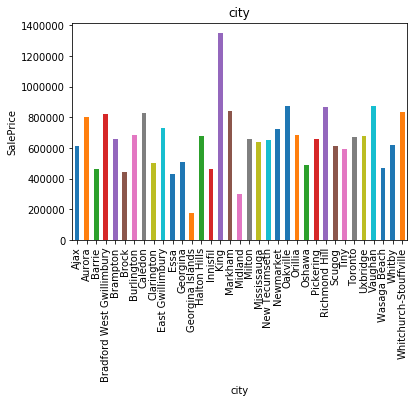

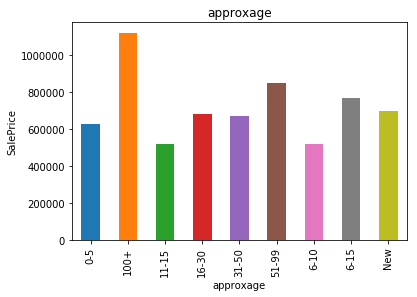

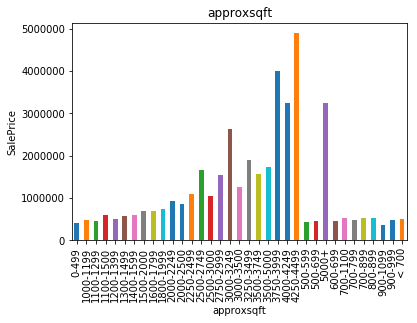

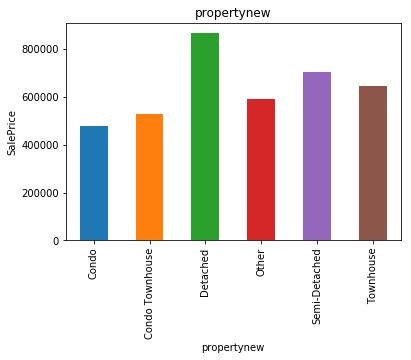

In [78]:
for var in cat_vars:
    analyse_discrete(df, var)  # using same function for numerical discrete vars

In [79]:
### Modifying Categorical Variable 'approxage' (Putting Similar logic like the rest)

In [80]:
df.loc[df.approxage=='15-Nov','approxage']='11-15'

In [81]:
df.loc[df.approxage=='15-Jun','approxage']='6-15'

In [82]:
df.loc[df.approxage=='10-Jun','approxage']='6-10'

In [83]:
df['approxage'].value_counts() # The labels under this category now looks fantastic!

0-5      4682
6-15     2860
16-30    2845
31-50    2106
51-99    1399
New      1130
6-10     1084
11-15     643
100+      381
Name: approxage, dtype: int64

In [84]:
df.shape

(39551, 20)

In [85]:
df.head(2)

,postcode,province,city,area,community,type,approxage,approxsqft,propertynew,bedroomstotal,kitchens,washrooms,maintenancefee,entrydate,solddate,soldprice,latitude,longitude,YM,lifeofad
122817,M2P1S4,Ontario,Toronto,Toronto,St. Andrew-Windfields,Sale,NaN,3500-5000,Detached,5,1.0,6.0,NaN,2017-09-07,2018-01-29,3250000.0,43.7568,-79.4012,2018-01,144
124383,M5V0J9,Ontario,Toronto,Toronto,Waterfront Communities C1,Sale,0-5,600-699,Condo,2,1.0,1.0,497.58,2017-09-15,2018-01-05,490000.0,NaN,NaN,2018-01,112


In [86]:
# dropping other unnecessary time vars 

In [87]:
df.drop(['entrydate','solddate','YM'],axis=1, inplace=True)

In [88]:
df.columns

Index(['postcode', 'province', 'city', 'area', 'community', 'type',
       'approxage', 'approxsqft', 'propertynew', 'bedroomstotal', 'kitchens',
       'washrooms', 'maintenancefee', 'soldprice', 'latitude', 'longitude',
       'lifeofad'],
      dtype='object')

In [89]:
df.dtypes

postcode           object
province           object
city               object
area               object
community          object
type               object
approxage          object
approxsqft         object
propertynew        object
bedroomstotal       int64
kitchens          float64
washrooms         float64
maintenancefee    float64
soldprice         float64
latitude          float64
longitude         float64
lifeofad            int64
dtype: object

In [90]:
df.head(2)

,postcode,province,city,area,community,type,approxage,approxsqft,propertynew,bedroomstotal,kitchens,washrooms,maintenancefee,soldprice,latitude,longitude,lifeofad
122817,M2P1S4,Ontario,Toronto,Toronto,St. Andrew-Windfields,Sale,NaN,3500-5000,Detached,5,1.0,6.0,NaN,3250000.0,43.7568,-79.4012,144
124383,M5V0J9,Ontario,Toronto,Toronto,Waterfront Communities C1,Sale,0-5,600-699,Condo,2,1.0,1.0,497.58,490000.0,NaN,NaN,112


In [91]:
df.shape

(39551, 17)

In [92]:
# saving a copy of first-cut filtered data before doing feature engineering 
#and later adding env vars(discussing with Google for possible student discount)
# the GeoCoding is cheaper but the NearBy search API is very costly

In [93]:
df.to_csv('df_wo_env.csv',index=False) 

# Later random records will be used as Alien data to test the 
#prediction power of the reressor engine

# 2.Feature Engineering

## Separating into train-test data sets

In [94]:
#separating into train and test data sets
# SEED=0

X_train, X_test, y_train, y_test = train_test_split(df, df.soldprice,
                                                    test_size=0.1,
                                                    random_state=0) # we are setting the seed here
X_train.shape, X_test.shape

((35595, 17), (3956, 17))

# Missing Value Imputation

## Categorical variables

In [95]:
# making a list of the categorical variables that contain missing values
vars_with_na = [var for var in df.columns if X_train[var].isnull().sum()>1 and X_train[var].dtypes=='O']

# printing the variables name and the missing values(value*100 to get % value)
for var in vars_with_na:
    print(var, np.round(X_train[var].isnull().mean(), 3))

approxage 0.567
approxsqft 0.317


In [96]:
X_train[X_train.approxage.isnull()==True].shape[0] # No of record loss if NaN is neglected

20183

In [97]:
# function to replace NANs in categorical variables
def fill_categorical_na(df, var_list):
    X = df.copy()
    X[var_list] = df[var_list].fillna('Missing')  # introducing 'Missing' Category
    return X

In [98]:
# replacing missing values with new label: "Missing"
X_train = fill_categorical_na(X_train, vars_with_na)
X_test = fill_categorical_na(X_test, vars_with_na)

# checking that no missing information exists in the engineered variables
X_train[vars_with_na].isnull().sum()

approxage     0
approxsqft    0
dtype: int64

In [99]:
# checking that both train and test set does not contain null values in the engineered variables
[vr for var in vars_with_na if X_train[var].isnull().sum()>0]

[]

In [100]:
[vr for var in vars_with_na if X_test[var].isnull().sum()>0]

[]

## Numerical variables 

In [101]:
# making a list of the numerical variables that contain missing values
vars_with_na = [var for var in df.columns if X_train[var].isnull().sum()>1 and X_train[var].dtypes!='O']

# printing the variable name and the missing values
for var in vars_with_na:
    print(var, np.round(X_train[var].isnull().mean(), 3))

kitchens 0.002
maintenancefee 0.619
soldprice 0.0
latitude 0.38
longitude 0.38


In [102]:
temp_vars=['latitude','longitude']

In [103]:
vars_with_na =[ var for var in vars_with_na if var not in temp_vars  ] # discarding lat and longs

In [104]:
vars_with_na

['kitchens', 'maintenancefee', 'soldprice']

### Discrete Variable 

In [105]:
d_vars=['kitchens','washrooms'] # washroom is taken forcefully to take care of zeros later

In [106]:
X_train.kitchens.median()

1.0

In [107]:
X_train.kitchens.value_counts()

1.0    34535
2.0      828
3.0       84
0.0       29
4.0       20
5.0        4
6.0        3
8.0        3
9.0        2
7.0        1
Name: kitchens, dtype: int64

In [108]:
X_train.washrooms.median()

2.0

In [109]:
X_train.washrooms.value_counts()

2.0     12198
3.0      8973
1.0      6435
4.0      6242
5.0      1247
6.0       285
0.0       107
7.0        65
8.0        21
9.0         9
11.0        5
10.0        4
13.0        2
15.0        1
27.0        1
Name: washrooms, dtype: int64

In [110]:
# replacing the missing values with modes
for var in d_vars:
    
    # calculate the mode
    mode_val = X_train[var].mode()[0]
    
    # train
    X_train[var+'_na'] = np.where(X_train[var].isnull(), 1, 0) # replacing NaNs with Mode Value
    X_train[var].fillna(mode_val, inplace=True)
    
    # test
    X_test[var+'_na'] = np.where(X_test[var].isnull(), 1, 0) # replacing NaNs with Mode Value
    X_test[var].fillna(mode_val, inplace=True)

# check that we have no more missing values in the engineered variables
X_train[d_vars].isnull().sum()

kitchens     0
washrooms    0
dtype: int64

In [111]:
# replacing Zeros with modes
for var in d_vars:
    
    # calculate the mode
    mode_val = X_train[var].mode()[0]   

    
    # train
    X_train.loc[X_train[var]==0,var]=mode_val
    
    # test
    X_test.loc[X_test[var]==0,var]=mode_val
# checking that no more zero values in the engineered variables
[vr for var in d_vars if X_train[X_train[var]==0].shape[0]]

[]

In [112]:
# checking for zero
[vr for var in d_vars if X_test[X_test[var]==0].shape[0]]

[]

In [113]:
vars_with_na =[ var for var in vars_with_na if var not in d_vars  ] # getting only continious vars

In [114]:
vars_with_na

['maintenancefee', 'soldprice']

### Continious variable

In [115]:
# replacing the missing values with medians as both distributions are non-Gaussian
for var in vars_with_na:
    
    # calculate the mode
    median_val = X_train[var].median()
    
    # train
    X_train[var+'_na'] = np.where(X_train[var].isnull(), 1, 0)
    X_train[var].fillna(median_val, inplace=True)
    
    # test
    X_test[var+'_na'] = np.where(X_test[var].isnull(), 1, 0)
    X_test[var].fillna(median_val, inplace=True)

# checking that no more missing values in the engineered variables
X_train[vars_with_na].isnull().sum()

maintenancefee    0
soldprice         0
dtype: int64

In [116]:
# replacing the zeros with medians 
for var in vars_with_na:
    
    # calculate the mode
    median_val = X_train[var].median()
    
    # train
    X_train.loc[X_train[var]==0,var]=median_val
    
    # test
    X_test.loc[X_test[var]==0,var]=median_val
# checking that no more zero values in the engineered variables
[vr for var in vars_with_na if X_train[X_train[var]==0].shape[0]]

[]

In [117]:
# checking that test set does not contain null values in the engineered variables
[vr for var in vars_with_na if X_test[var].isnull().sum()>0]

[]

In [118]:
# checking for zero
[vr for var in vars_with_na if X_test[X_test[var]==0].shape[0]]

[]

In [119]:
df[df.lifeofad.isnull()==True].shape[0] # Recheckin no NaN in Temp Var

0

# Handling Outliers in Categorical Variables by Rare Labels

In [120]:
cat_vars=['city','approxage','approxsqft','propertynew']

In [121]:
def find_frequent_labels(df, var, rare_perc):
    # finding the labels that are shared by NOT more than a certain%(here 1%)
    #of the records in the entire dataset i.e. df
    df = df.copy()
    tmp = df.groupby(var)['soldprice'].count() / len(df)
    return tmp[tmp<rare_perc].index, tmp[tmp>rare_perc].index

d={}
for var in cat_vars:
    rarevars,frequent_ls = find_frequent_labels(X_train, var, 0.01)
    
    if len(rarevars)!=0:
        d[var]=rarevars.tolist()
        
    X_train[var] = np.where(X_train[var].isin(frequent_ls), X_train[var], 'Rare') # introducing Rare label
    X_test[var] = np.where(X_test[var].isin(frequent_ls), X_test[var], 'Rare')

In [122]:
#d # labels go under rare labels - need this for checking in web development 

In [123]:
X_train[(X_train.approxage=='Rare') | (X_train.approxsqft=='Rare') | (X_train.city=='Rare') ].shape[0]
# of Rare labels

2730

# Encoding CategoricalVariables

In [124]:
# this function will assign discrete values to the categorical variables, 
# so that the smaller value corresponds to the smaller mean of target( here soldprice)

def replace_categories(train, test, var, target):
    ordered_labels = train.groupby([var])[target].mean().sort_values().index
    ordinal_label = {k:i for i, k in enumerate(ordered_labels, 0)} # to be pickled
    train[var] = train[var].map(ordinal_label)
    test[var] = test[var].map(ordinal_label)
    return ordinal_label

In [125]:
d1={}
for var in cat_vars:
    vals= replace_categories(X_train, X_test, var, 'soldprice')
    d1[var]=vals

In [126]:
d1 # req for web dev

{'city': {'Barrie': 0,
  'Oshawa': 1,
  'Clarington': 2,
  'Ajax': 3,
  'Whitby': 4,
  'Brampton': 5,
  'Milton': 6,
  'Pickering': 7,
  'Mississauga': 8,
  'Burlington': 9,
  'Newmarket': 10,
  'Rare': 11,
  'Toronto': 12,
  'Aurora': 13,
  'Markham': 14,
  'Caledon': 15,
  'Vaughan': 16,
  'Richmond Hill': 17,
  'Oakville': 18},
 'approxage': {'11-15': 0,
  '6-10': 1,
  '31-50': 2,
  '16-30': 3,
  '0-5': 4,
  'Missing': 5,
  'New': 6,
  '6-15': 7,
  '51-99': 8,
  'Rare': 9},
 'approxsqft': {'0-499': 0,
  '500-599': 1,
  '600-699': 2,
  '700-799': 3,
  '900-999': 4,
  '1000-1199': 5,
  '800-899': 6,
  '1200-1399': 7,
  '1400-1599': 8,
  '1100-1500': 9,
  '1500-2000': 10,
  '1600-1799': 11,
  'Missing': 12,
  '2000-2500': 13,
  '2500-3000': 14,
  'Rare': 15,
  '3000-3500': 16,
  '3500-5000': 17},
 'propertynew': {'Condo': 0,
  'Condo Townhouse': 1,
  'Other': 2,
  'Townhouse': 3,
  'Semi-Detached': 4,
  'Detached': 5}}

In [127]:
with open('mapdict.pkl','wb') as f:    # saving component for web dev
    pickle.dump(d1,f)

In [128]:
X_train.head()

,postcode,province,city,area,community,type,approxage,approxsqft,propertynew,bedroomstotal,kitchens,washrooms,maintenancefee,soldprice,latitude,longitude,lifeofad,kitchens_na,washrooms_na,maintenancefee_na,soldprice_na
611422,L6Y0Y5,Ontario,5,Peel,Credit Valley,Sale,4,14,5,6,1.0,5.0,495.29,970000.0,NaN,NaN,1,0,0,1,0
619026,M9W7J4,Ontario,12,Toronto,West Humber-Clairville,Sale,5,3,0,2,1.0,1.0,436.00,364900.0,43.7247,-79.6153,7,0,0,0,0
633070,L1T0B1,Ontario,3,Durham,Central,Sale,5,12,3,3,1.0,2.0,495.29,478000.0,43.8604,-79.0333,35,0,0,1,0
625876,L7R2W4,Ontario,9,Halton,Brant,Sale,8,13,5,3,1.0,2.0,495.29,940000.0,43.3312,-79.7898,2,0,0,1,0
375866,L7B1N1,Ontario,11,York,Nobleton,Sale,4,15,5,4,1.0,5.0,495.29,2375000.0,NaN,NaN,65,0,0,1,0


In [129]:
# ensuring the  absence of nan in train data set
[var for var in X_train.columns if X_train[var].isnull().sum()>0]

['latitude', 'longitude']

In [130]:
# ensuring the absence of nan in test data set
[var for var in X_test.columns if X_test[var].isnull().sum()>0]

['latitude', 'longitude']

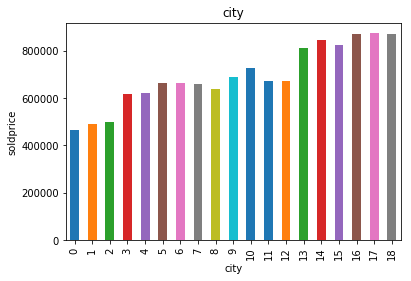

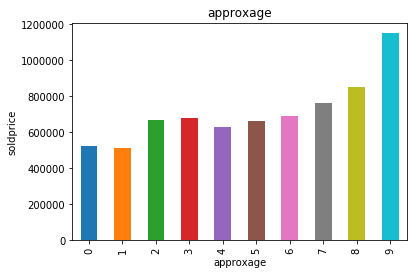

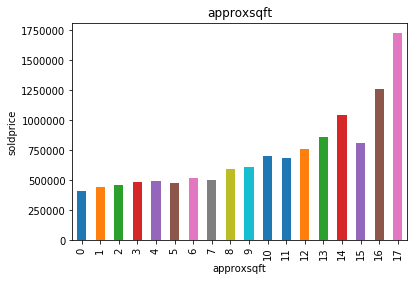

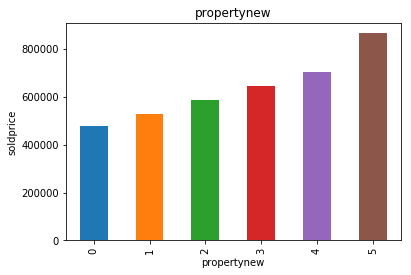

In [131]:
# relationship between engineered cat vars and soldprice
def analyse_vars(df, var):
    df = df.copy()
    df.groupby(var)['soldprice'].median().plot.bar() # plot based on median
    plt.title(var)
    plt.ylabel('soldprice')
    plt.show()
    
for var in cat_vars:
    analyse_vars(X_train, var)

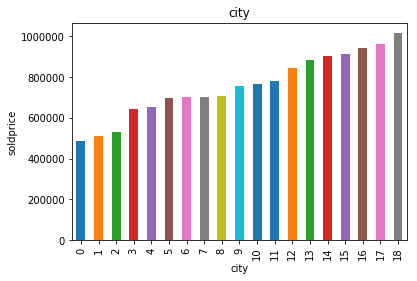

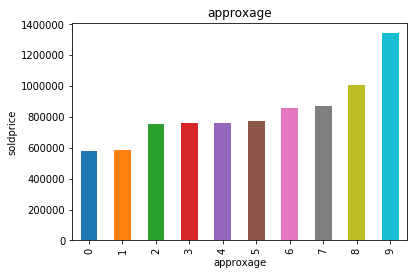

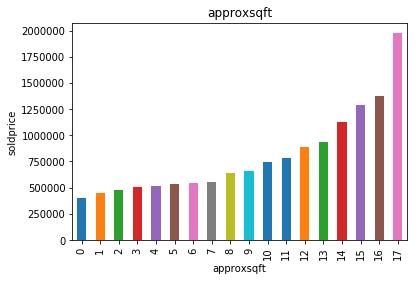

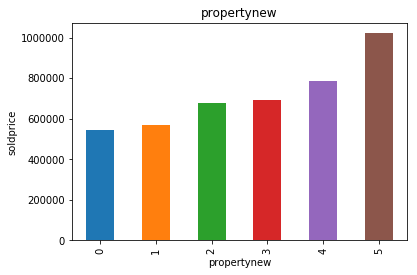

In [132]:
# relationship between engineered cat vars and soldprice
def analyse_vars(df, var):
    df = df.copy()
    df.groupby(var)['soldprice'].mean().plot.bar() # plot based on mean
    plt.title(var)
    plt.ylabel('soldprice')
    plt.show()
    
for var in cat_vars:
    analyse_vars(X_train, var)

In [133]:
# now mostly monotonic relationship can be seen now

In [134]:
# making a list of the numerical variables that contain missing values
vars_with_na = [var for var in df.columns if X_train[var].dtypes!='O']

# print the variable name and the percentage of missing values
for var in vars_with_na:
    print(var, np.round(X_train[var].isnull().mean(), 3))

city 0.0
approxage 0.0
approxsqft 0.0
propertynew 0.0
bedroomstotal 0.0
kitchens 0.0
washrooms 0.0
maintenancefee 0.0
soldprice 0.0
latitude 0.38
longitude 0.38
lifeofad 0.0


In [135]:
# All categorical variables got converted to numerical
# lat n longs are disregarded

In [136]:
# making a list of the non- numerical variables that contain missing values
## only variables that are just kept for information
vars_with_na = [var for var in df.columns if X_train[var].dtypes=='O']

# print the variable name and the missing values
for var in vars_with_na:
    print(var, np.round(X_train[var].isnull().mean(), 3))

postcode 0.0
province 0.0
area 0.0
community 0.0
type 0.0


In [137]:
cont_vars=['maintenancefee','soldprice'] # getting continious variables

In [138]:
X_train.shape

(35595, 21)

In [139]:
X_test.shape

(3956, 21)

## Outlier Removal in Continious Numerical Variables by both-end capping( all have Skewed Distributions)

In [140]:
def Outlier_cont_num_var(df,var):    
    df=df.copy()    
    IQR = df[var].quantile(0.75) - df[var].quantile(0.25)
    upper_fence = df[var].quantile(0.75) + (IQR * 3)
    lower_fence = df[var].quantile(0.25) - (IQR * 3)
    
    upper_capp= df[var].quantile(0.95)
    lower_capp = df[var].quantile(0.25)
    
    up= 0.05 # upper cut-off , user to set by trial and error
    #lp=0.05 # lower cutoff, user to set by trial and error
    
    print('var:{}'.format(var))    
    print('max:{},min:{}'.format(df[var].max(),df[var].min()))
    print('upper cut-off:{}'.format(up))
    print('upperfence:{},lowerfence:{}'.format(upper_fence,lower_fence))
    print('uppercapp:{},lowercapp:{}'.format(upper_capp,lower_capp))
    
    
    nu1= len(df[df[var] > upper_fence]) / len(df)
    nu2= len(df[df[var] > upper_capp]) / len(df)
    
 
    if upper_capp<upper_fence and nu2<up and IQR!=0:
        upper = upper_capp
    elif (upper_fence<upper_capp or upper_fence==upper_capp) and nu1<up and IQR!=0:
        upper= upper_fence
    else:
        upper= None
        
    #nl1= len(df[df[var] < lower_fence]) / len(df)
    #nl2= len(df[df[var] < lower_capp]) / len(df)
    
            
    if lower_fence >0 and lower_fence>lower_capp : #and nl1<lp
        lower=lower_fence
    elif lower_capp>lower_fence or lower_fence==lower_capp : #and nl2<lp
        lower=lower_capp
    else:
        lower= None
    
    print('upper:{},lower:{}'.format(upper,lower))
    print('\n')
    
    return lower, upper


# Logic: 
# taking min(upper_fence,upper_capp) and max(lower_fence,lower_capp)
# if outlier> 15%, these are no more outliers and variable distribution is kept as it is(striked out)
        
    

In [141]:
dl={}
du={}

for var in cont_vars:
    low, up =Outlier_cont_num_var(X_train,var)
    
    if low!=None:
        dl[var]=low
    if up!= None:
        du[var]=up  
    

var:maintenancefee
max:6211.82,min:0.21
upper cut-off:0.05
upperfence:495.29,lowerfence:495.29
uppercapp:790.3489999999995,lowercapp:495.29
upper:None,lower:495.29


var:soldprice
max:17395000.0,min:729.0
upper cut-off:0.05
upperfence:2097000.0,lowerfence:-697750.0
uppercapp:1600000.0,lowercapp:500000.0
upper:1600000.0,lower:500000.0




In [142]:
du # capping upper dict

{'soldprice': 1600000.0}

In [143]:
dl # capping lower dict

{'maintenancefee': 495.29, 'soldprice': 500000.0}

In [144]:
from feature_engine import outlier_removers as outr

if len(du)!=0 or len(dl)!=0:

    if len(du)!=0 and len(dl)!=0:
        capper = outr.ArbitraryOutlierCapper(max_capping_dict = du, min_capping_dict = dl)
        capper.fit(X_train)
    elif len(du)!=0 and len(dl)==0:
        capper = outr.ArbitraryOutlierCapper(max_capping_dict = du, min_capping_dict = None)
        capper.fit(X_train)
    elif len(dl)!=0 and len(du)==0:
        capper = outr.ArbitraryOutlierCapper(max_capping_dict = None, min_capping_dict = dl)
        capper.fit(X_train)
    
    X_train = capper.transform(X_train)
    X_test = capper.transform(X_test)
    

ModuleNotFoundError: No module named 'feature_engine'

In [ ]:
webdict={'maintenancefee': 495.29} # taking only maintenance for prediction against alien data

In [ ]:
capper = outr.ArbitraryOutlierCapper(max_capping_dict = None, min_capping_dict = webdict)

In [ ]:
with open('outlier_capper.pkl','wb') as f: # capper required for web development
    pickle.dump(capper,f)

In [ ]:
X_train.maintenancefee.max(),X_train.maintenancefee.min()

In [ ]:
X_train.soldprice.max(),X_train.soldprice.min()

In [ ]:
dp_loss= df.shape[0]-X_train.shape[0]-X_test.shape[0]

In [ ]:
dp_loss # no loss in data points during FE

## Log transformation of soldprice

In [ ]:
    X_train['soldprice'] = np.log(X_train['soldprice']) 
    X_test['soldprice']= np.log(X_test['soldprice'])
    # Lasso require gaussian distribution for IDVs and the DV

## Best place to add correct lat/long values and other env variables

## Feature Scaling

In [ ]:
len(X_train.columns)

In [ ]:
X_train.columns

In [ ]:
info_vars=['postcode', 'province','area','community','type','latitude','longitude','soldprice']

In [ ]:
train_vars = [var for var in X_train.columns if var not in info_vars]
len(train_vars)

In [ ]:
train_vars # features considered for analysis before feature selection

In [ ]:
# fit scaler
scaler = MinMaxScaler() # create an instance
scaler.fit(X_train[train_vars]) #  fit  the scaler to the train set for later use

# transform the train and test set, and add on the Id and SalePrice variables
X_train = pd.concat([X_train[info_vars].reset_index(drop=True),
                    pd.DataFrame(scaler.transform(X_train[train_vars]), columns=train_vars)],
                    axis=1)

X_test = pd.concat([X_test[info_vars].reset_index(drop=True),
                    pd.DataFrame(scaler.transform(X_test[train_vars]), columns=train_vars)],
                    axis=1)

In [ ]:
import pickle

In [ ]:
with open('scaler.pkl','wb') as f: # saving the scaler for web dev
    pickle.dump(scaler,f)

In [ ]:
X_train.head()

In [ ]:
# check absence of missing values
X_train.isnull().sum()

In [ ]:
# let's now save the train and test sets for the next notebook!

X_train.to_csv('xtrain.csv', index=False)
X_test.to_csv('xtest.csv', index=False)

In [ ]:
xtrain=pd.read_csv('xtrain.csv')

In [ ]:
y_train=xtrain['soldprice']

In [ ]:
x_train=xtrain[train_vars]

In [ ]:
x_train.head()

In [ ]:
xtest=pd.read_csv('xtest.csv')

In [ ]:
y_test=xtest['soldprice']

In [ ]:
x_test=xtest[train_vars]

# 3.HYPER PARAMETER TUNING with GRID SEARCH

In [ ]:
model=Lasso(alpha=0.05,random_state=0)

In [ ]:
model.get_params().keys()

In [ ]:
model.get_params()['alpha']

In [ ]:
from sklearn.model_selection import GridSearchCV
params = {'alpha':[1e-06,0.00001,0.0001,0.002,0.05]}
model = GridSearchCV(model, params, cv=10,scoring='neg_mean_squared_error')
model.fit(x_train,y_train)
a= model.best_params_

a['alpha']

In [ ]:
score=-model.best_score_
np.sqrt(score)

In [ ]:
print(model.best_estimator_)

In [ ]:
print(model)

In [ ]:
model=Lasso(alpha=a['alpha'],random_state=0) # Intermediate Model

# 4.Feature Selection

In [ ]:
sel=SelectFromModel(model) 

In [ ]:
sel.fit(x_train,y_train) 

In [ ]:
a=sel.get_support()
sfeat=x_train.columns[a]
sfeat=list(sfeat)
sfeat # selected features

In [ ]:
with open('features.pkl','wb') as f:
    pickle.dump(sfeat,f)

In [ ]:
x_train.columns

In [ ]:
len(x_train.columns)

In [ ]:
len(sfeat)

In [ ]:
xtrain_sel=x_train[sfeat]
xtest_sel=x_test[sfeat]
#converting train and test datasets to main features only

# 5.Final ML MODEL BUILDING

In [ ]:
print(model)

In [ ]:
model.fit(xtrain_sel,y_train) # final model

# 6.Estimation of RMSE<i.e.Error of the regressor Engine>

In [ ]:
y_pred1=model.predict(xtrain_sel) # pred based on train set 
y_pred2=model.predict(xtest_sel) # prediction based on test set

In [ ]:
    from sklearn.metrics import mean_squared_error
   
    error_rmse_1 = np.sqrt(mean_squared_error(np.exp(y_train),np.exp(y_pred1))) #calculate rmse

    error_rmse_1 # based on train set

In [ ]:
    from sklearn.metrics import mean_squared_error

    error_rmse_2 = np.sqrt(mean_squared_error(np.exp(y_test),np.exp(y_pred2))) #calculate rmse

    error_rmse_2 # based on test set

In [ ]:
err1= abs(np.exp(y_pred1)-np.exp(y_train))*100/np.exp(y_train)
err1.mean() # absolute mean

In [ ]:
err2= abs(np.exp(y_pred2)-np.exp(y_test))*100/np.exp(y_test)
err2.mean() # absolute mean

In [ ]:
pd.DataFrame({'err1':err1,'err2':err2}).head() # err1.mean()~ err2.mean(), Little under fitting

In [ ]:
pause

In [ ]:
#Evaluating predictions w.r.t the original price
plt.scatter(y_test, y_pred2)
plt.xlabel('True House Price')
plt.ylabel('Predicted House Price')
plt.title('Evaluation of Lasso Predictions')

In [ ]:
# Evaluating the distribution of the errors: 
# check of normal distribution- model performance

errors = y_test - y_pred2
errors.hist(bins=15)

In [ ]:
### Feature importance

In [ ]:
model.coef_.ravel()

In [ ]:
#  Feature importance bar plot

importance = pd.Series(np.abs(model.coef_.ravel()))
importance.index = sfeat
importance.sort_values(inplace=True, ascending=False)
importance.plot.bar(figsize=(18,6))
plt.ylabel('Lasso Coefficients')
plt.title('Feature Importance')

# 7.Final Regressor Engine Serealization

In [ ]:
import pickle

In [ ]:
with open('engine.pkl', 'wb') as f:
    pickle.dump(model, f)

In [ ]:
with open('engine.pkl', 'rb') as f:
    engine = pickle.load(f)

In [ ]:
engine

In [ ]:
xtest_sel.head(1)

In [ ]:
#d1

In [ ]:
pause # execution of next cells to be done manually one-by-one

# 8.Regressor engine applied to alien data to check it's prediction power and the correctness of web dev components

In [ ]:
with open('mapdict.pkl','rb') as f:
    d1=pickle.load(f)

In [ ]:
d1

In [ ]:
l5=list(d1['city'].keys())
l5

In [ ]:
var_city= input('City:')
var_city=var_city[0].upper()+var_city[1:].lower()
if var_city in d1['city'].keys():
    var_city= int(d1['city'][var_city])
else:
    var_city= int(d1['city']['Rare'])

In [ ]:
var_city

In [ ]:
l1=list(d1['approxage'].keys())
l1

In [ ]:
var_approxage= input('Property age range in yrs:')
#var_approxage=var_approxage[0].upper()+var_approxage[1:].lower()
if var_approxage in d1['approxage'].keys():
    var_approxage= int(d1['approxage'][var_approxage])
else:
    var_approxage= int(d1['approxage']['Rare'])

In [ ]:
var_approxage

In [ ]:
l3=list(d1['approxsqft'].keys())
l3

In [ ]:
var_approxsqft= input('Property Area range in sqft:')
#var_approxsqft=var_approxsqft[0].upper()+var_approxsqft[1:].lower()
if var_approxsqft in d1['approxsqft'].keys():
    var_approxsqft= int(d1['approxsqft'][var_approxsqft])
else:
    var_approxsqft= int(d1['approxsqft']['Rare'])

In [ ]:
var_approxsqft

In [ ]:
l2=list(d1['propertynew'].keys())
l2

In [ ]:
var_propertynew= input('Property Type:')
var_propertynew=var_propertynew[0].upper()+var_propertynew[1:].lower()
if var_propertynew in d1['propertynew'].keys():
    var_propertynew= int(d1['propertynew'][var_propertynew])
else:
    var_propertynew= int(d1['propertynew']['Rare'])

In [ ]:
var_propertynew

In [ ]:
var_bedroomstotal=int(input('Total No of Bedrooms:'))

In [ ]:
var_kitchens=int(input('Total No of Kitchens:'))

In [ ]:
var_washrooms=int(input('Total No of Washrooms:'))

In [ ]:
var_maintenancefee=float(input('Approx Yearly Maintenance Fee:'))

In [ ]:
var_lifeofad=int(input('How many days back the ad is listed from today- less than 180 days:'))

In [ ]:
# sample input creation

In [ ]:
xtest_dummy=pd.read_csv('df_wo_env.csv')

In [ ]:
xtest_dummy.iloc[25:30,:]

In [ ]:
alien_data={'city':var_city,'approxage':var_approxage,'approxsqft':var_approxsqft,'propertynew':var_propertynew,\
           'bedroomstotal':var_bedroomstotal,'kitchens':var_kitchens,'washrooms':var_washrooms,\
           'maintenancefee':var_maintenancefee,'lifeofad':var_lifeofad,'kitchens_na':0,'washrooms_na':0\
            ,'maintenancefee_na':0,'soldprice_na':0}

In [ ]:
len(alien_data)

In [ ]:
aliendata=pd.DataFrame(alien_data,index=[0],columns=alien_data.keys()) # single input

In [ ]:
#X_train[train_vars].head(1)

In [ ]:
aliendata.head()

In [ ]:
cols= aliendata.columns

In [ ]:
aliendata.columns.shape[0]

In [ ]:
with open('outlier_capper.pkl','rb') as f:
    capper=pickle.load(f)

In [ ]:
capper.fit(aliendata)

In [ ]:
aliendata=capper.transform(aliendata)

In [ ]:
with open('scaler.pkl','rb') as f:
    scaler=pickle.load(f)

In [ ]:
#pd.DataFrame(scaler.transform(X_test[train_vars]), columns=train_vars)

In [ ]:
aliendata_tr= pd.DataFrame(scaler.transform(aliendata), columns=cols)

In [ ]:
with open ('features.pkl','rb') as f:
    features= pickle.load(f)

In [ ]:
aliendata_sel=aliendata_tr[features]

In [ ]:
aliendata_sel.head(1)

In [ ]:
with open('engine.pkl', 'rb') as f:
    engine = pickle.load(f)

In [ ]:
alienprice_pred=engine.predict(aliendata_sel)

In [ ]:
alienprice_pred

In [ ]:
alienprice_pred= np.exp(alienprice_pred)
print('house price:',round(alienprice_pred[0],2))

## Reference